# <font size='+3'><center>Complete Walkthrough through NLP</center></font>

<hr>

<div class="list-group" id="list-tab" role="tablist">
  <h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">&nbsp;Table of Contents:</h1>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile">Importing Libraries<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="messages">Reading and Inspecting Data<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#3" role="tab" aria-controls="settings">Text PreProcessing<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#4" role="tab" aria-controls="settings">Transforming Tokens to a Vector<span class="badge badge-primary badge-pill">4</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="settings">Modelling<span class="badge badge-primary badge-pill">5</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#6" role="tab" aria-controls="settings">Submission<span class="badge badge-primary badge-pill">6</span></a> 
</div>

<a id="1"></a>
## Importing Libraries
Importing Necessary Libraries for this guide

In [1]:
import numpy as np 
import pandas as pd 
import re
import string
import nltk
from nltk.corpus import stopwords
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection, feature_extraction, linear_model
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from collections import defaultdict

<a id='2'></a>
## Reading and Inspecting Data

**Section Contents:**
- Read Data 
- Missing Values 
- Viewing tweets
- Inspecting target feature
- Inspecting keyword feature
- Inspecting location feature

### Read Data

In [3]:
# Reading in data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# Dimensions of train data
print("Train Dimensions: ", train.shape)
# Dimensions of test data
print("Test Dimensions: ", test.shape)

Train Dimensions:  (7613, 5)
Test Dimensions:  (3263, 4)


Our train data contains:
- 7613 rows
- 5 Columns

Our test data contains:
- 3263 rows
- 4 Columns

In [5]:
# Viewing first 5 rows of train data
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Viewing first 5 rows of test data
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


After viewing the data:
- Train data consists of 5 features (id, keyword, location, text and target)
- Test data consists of 4 features (id, keyword, location, and text)

**Note:** Remember Test data doesnt contain the'target' because that is what we are trying to predict with our train data!

### What do these features mean?
- `id`: Used for submission
- `keyword`: Keyword of the tweet
- `location`: Location the tweet was sent from
- `text`: The Tweet itself

### Missing Values

Checking the count and percentage of missing values

In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

**Train Data Missing Count:**
- 61 Keywords Values
- 2533 Location Values

**Test Data Missing Count:**
- 26 Keyword Values
- 1105 Keyword values

**Lets check the percentage of missing values**

In [9]:
# Creating dataframe with percentage of missing values for train data

train_perc_missing = train.isnull().mean()*100
percentage_missing = pd.DataFrame({'Train Missing Percentage': train_perc_missing.sort_values(ascending=False)})
percentage_missing

,Train Missing Percentage
location,33.272035
keyword,0.801261
id,0.000000
text,0.000000
target,0.000000


In [10]:
# Creating dataframe with percentage of missing values for test data

test_perc_missing = test.isnull().mean()*100
percentage_missing = pd.DataFrame({'Test Missing Percentage': test_perc_missing.sort_values(ascending=False)})
percentage_missing

,Test Missing Percentage
location,33.864542
keyword,0.796813
id,0.000000
text,0.000000


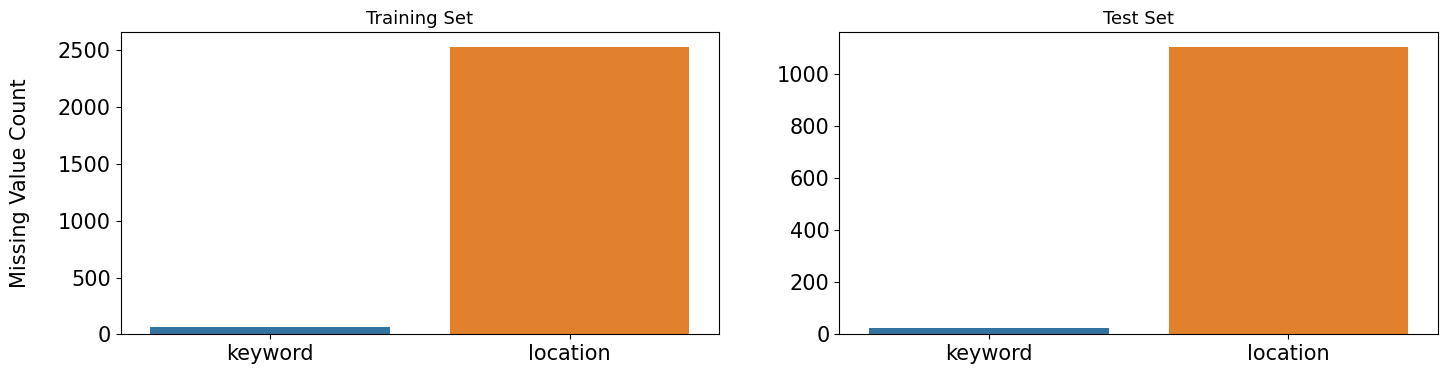

In [11]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train[missing_cols].isnull().sum().index, y=train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test[missing_cols].isnull().sum().index, y=test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

**Based on observing train and test missing percentage:**

- They are missing roughly 33% of their location values
- They are missing roughly 0.8% of their keyword values

### Viewing our Tweets

Viewing examples of random tweets

Random Example of a **NON-DISASTROUS** Tweet:

In [12]:
# Selecting 'text' values that are non-disastrous
non_disastrous = train[train['target']==0]['text']

# I inputted 4 to select the 4th row of the non-disastrous values
non_disastrous.values[4]

'What a goooooooaaaaaal!!!!!!'

Random Example of a **DISASTROUS** Tweet:

In [13]:
# Selecting 'text' values that are disastrous
disastrous = train[train['target']==1]['text']

# I inputted 2 to select the 2th row of the disastrous values
disastrous.values[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

As you can see the tweets are very different, finally we will inspect the **target column**

### Inspecting Target Feature

In [14]:
# Viewing number of disastrous and non disastrous tweets
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

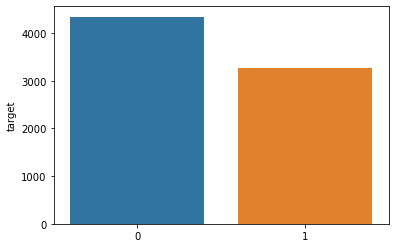

In [15]:
# Plotting number of disastrous and non disastrous tweets
sns.barplot(train['target'].value_counts().index, train['target'].value_counts())

In [16]:
train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7613,7613,7613,7613.00000
unique,NaN,222,3342,7503,NaN
top,NaN,no_keyword,no_location,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,61,2533,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [17]:
train.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


0    1458
1    1075
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x1704763b730>,
 [Text(-0.24110481617711207, 1.0732513534192263, '0'),
  Text(0.24110481617711216, -1.0732513534192263, '1')],
 [Text(-0.13151171791478838, 0.5854098291377597, '57%'),
  Text(0.13151171791478844, -0.5854098291377597, '43%')])

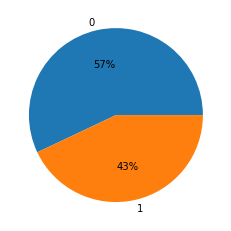

In [62]:
trainlocloss=train[train['location']=='no_location']
print(trainlocloss['target'].value_counts())
#sns.barplot(trainlocloss['target'].value_counts().index, train['target'].value_counts())
plt.pie(train['target'].value_counts(),labels=trainlocloss['target'].value_counts().index, autopct = '%0.0f%%',)

0    2884
1    2196
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x170476630d0>,
 [Text(-0.24110481617711207, 1.0732513534192263, '0'),
  Text(0.24110481617711216, -1.0732513534192263, '1')],
 [Text(-0.13151171791478838, 0.5854098291377597, '57%'),
  Text(0.13151171791478844, -0.5854098291377597, '43%')])

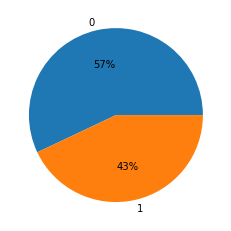

In [60]:
trainlocloss=train[train['location']!='no_location']
print(trainlocloss['target'].value_counts())
#sns.barplot(trainlocloss['target'].value_counts().index, train['target'].value_counts())
plt.pie(train['target'].value_counts(),labels=trainlocloss['target'].value_counts().index, autopct = '%0.0f%%',)

There are more non-disastrous tweets than disastrous tweets

### Inspecting Keyword Feature

Inspecting number of unique values and the first 20 most common keywords

0    4323
1    3229
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x17045682520>,
 [Text(-0.24814959434747694, 1.0716444274222596, '0'),
  Text(0.24814959434747677, -1.0716444274222598, '1')],
 [Text(-0.13535432418953286, 0.5845333240485052, '57%'),
  Text(0.13535432418953278, -0.5845333240485052, '43%')])

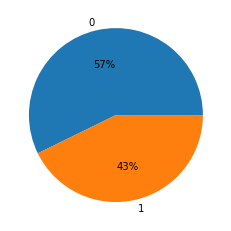

In [67]:
trainkeyloss=train[train['keyword']!='no_keyword']
print(trainkeyloss['target'].value_counts())
plt.pie(trainkeyloss['target'].value_counts(),labels=trainkeyloss['target'].value_counts().index, autopct = '%0.0f%%',)

1    42
0    19
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x170432e87f0>,
 [Text(0.6140681334515675, 0.9126446885175566, '0'),
  Text(-0.6140681334515674, -0.9126446885175566, '1')],
 [Text(0.3349462546099459, 0.49780619373684903, '31%'),
  Text(-0.3349462546099458, -0.49780619373684903, '69%')])

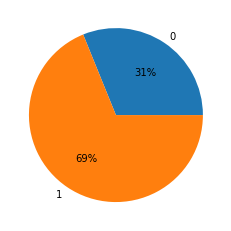

In [71]:
trainkeyloss=train[train['keyword']=='no_keyword']
print(trainkeyloss['target'].value_counts())
plt.pie(trainkeyloss['target'].value_counts(sort=False),labels=[0,1], autopct = '%0.0f%%',)

In [22]:
# Checking number of unique values in 'keyword' feature
train['keyword'].nunique()

222

There are clearly too many different keywords (221), so we will see the most common keywords

<AxesSubplot:xlabel='keyword'>

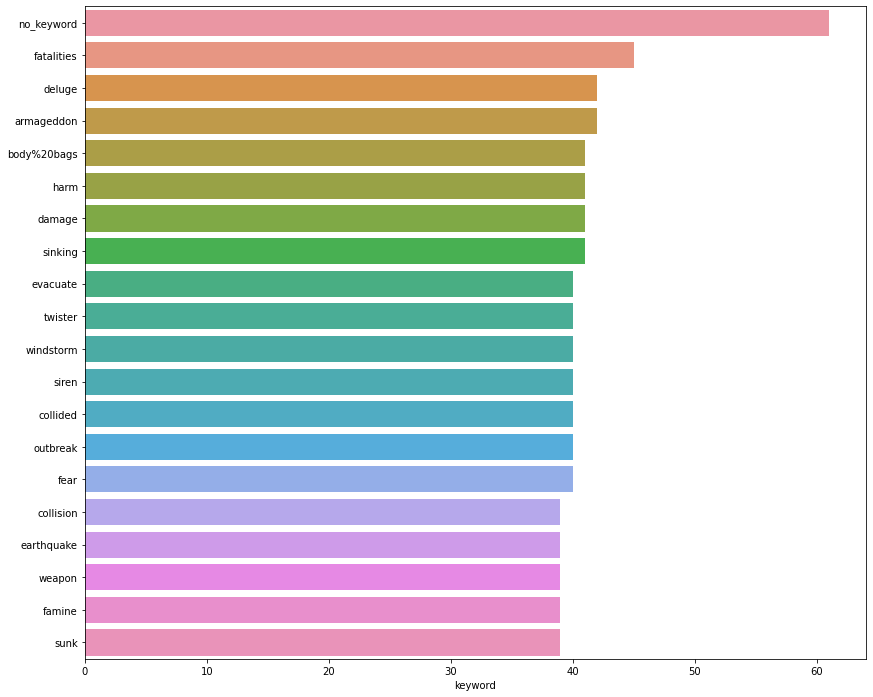

In [23]:
# Plotting the first 20 most common keywords
figure = plt.figure(figsize=(14,12))
sns.barplot(y=train['keyword'].value_counts().index[:20], x=train['keyword'].value_counts()[:20])

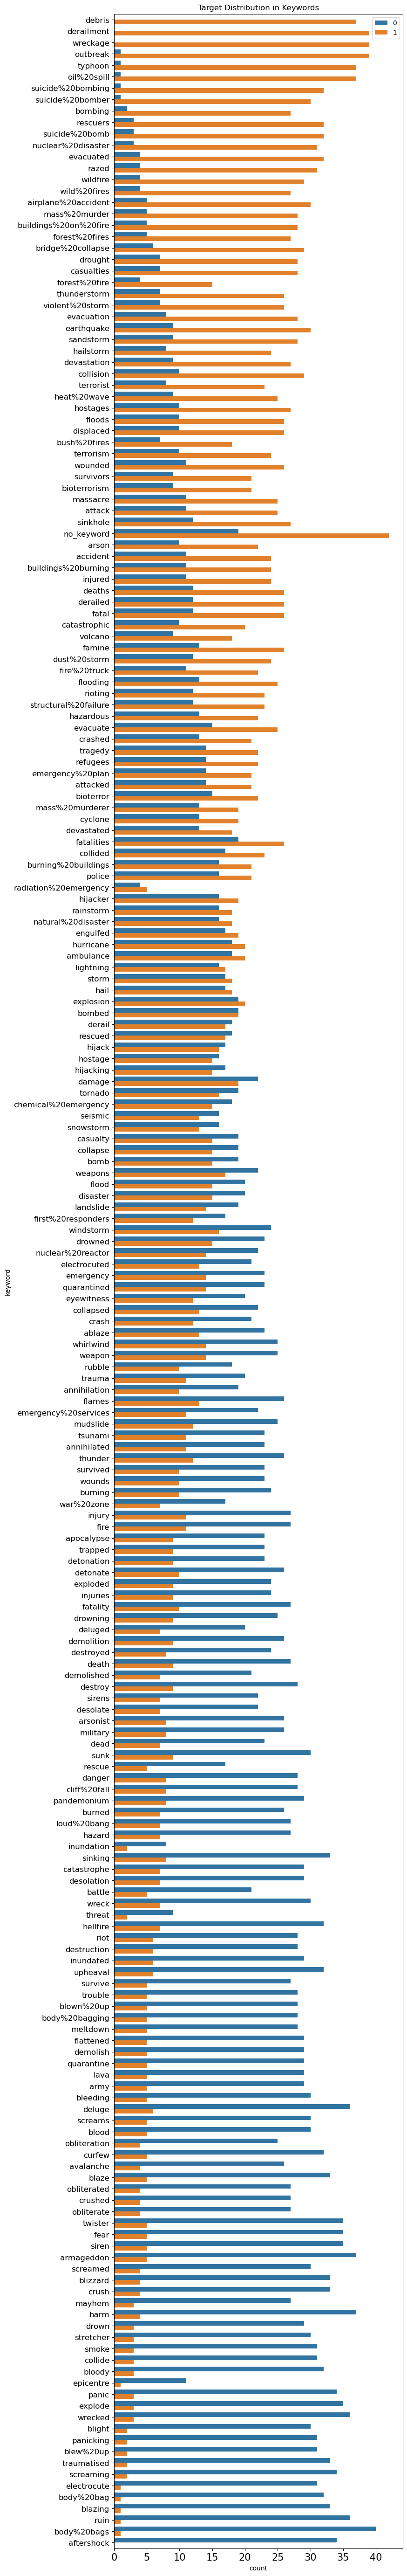

In [24]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

In [25]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train['target'] == 1

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]
# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


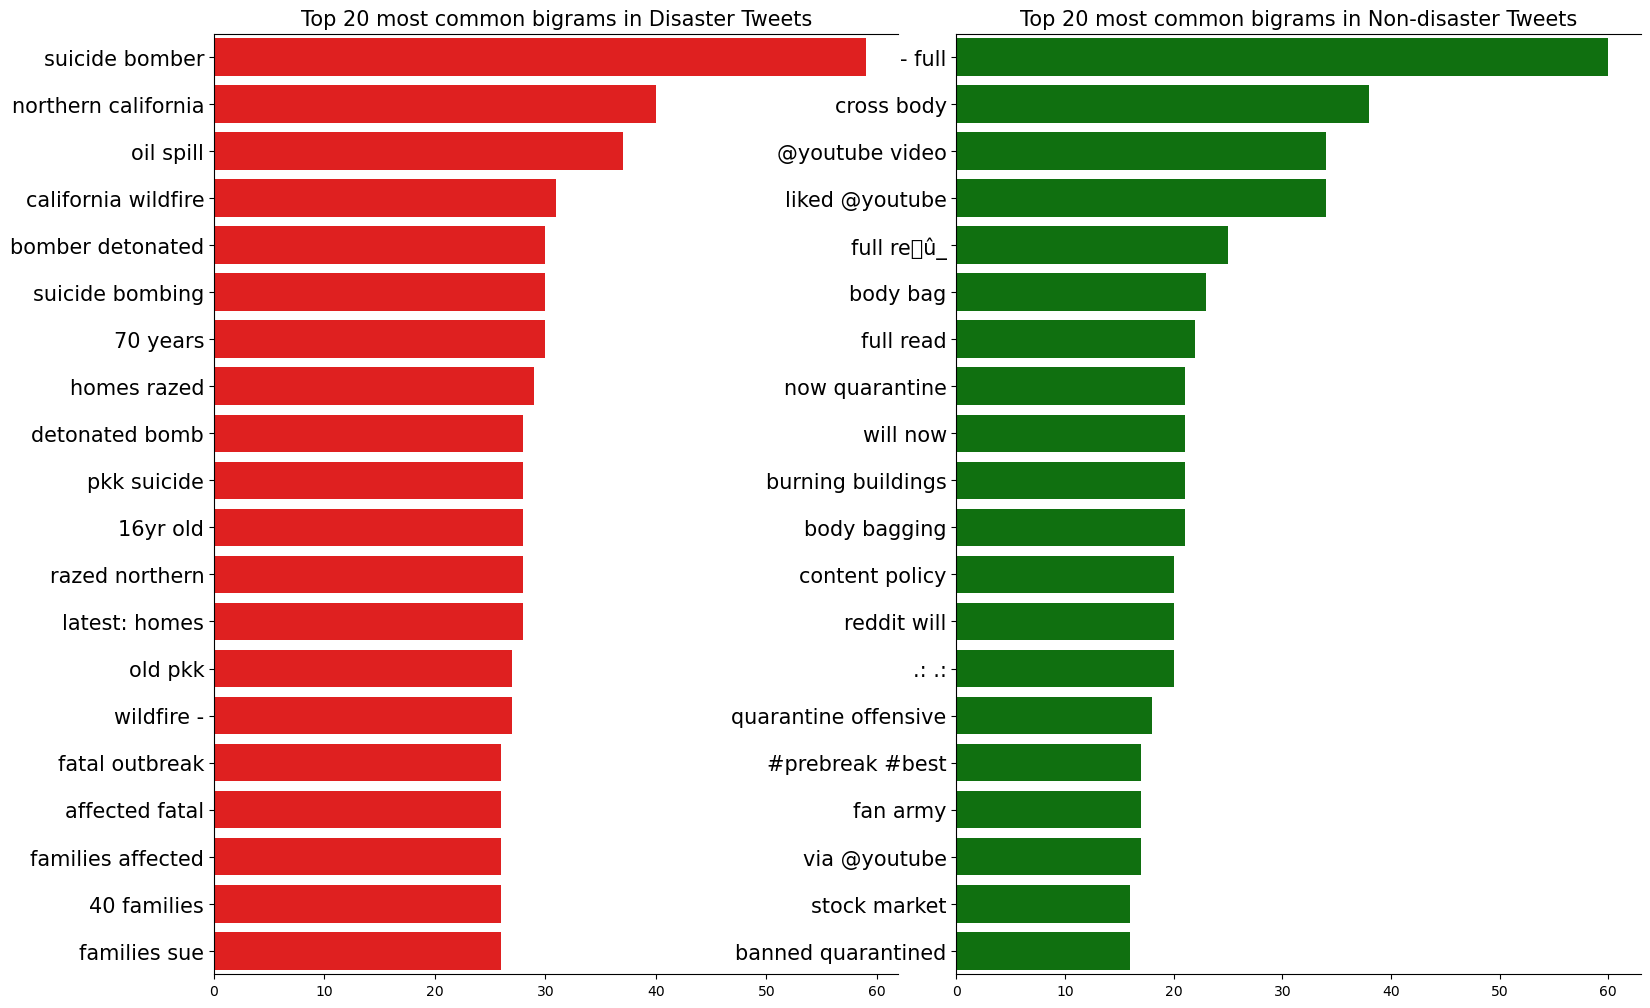

In [76]:
fig, axes = plt.subplots(ncols=2, figsize=(15,10), dpi=100)
plt.tight_layout()
N=20
sns.barplot(y=disaster_bigrams[0].values[:N], x=disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=nondisaster_bigrams[0].values[:N], x=nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

Meta Feature

In [27]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

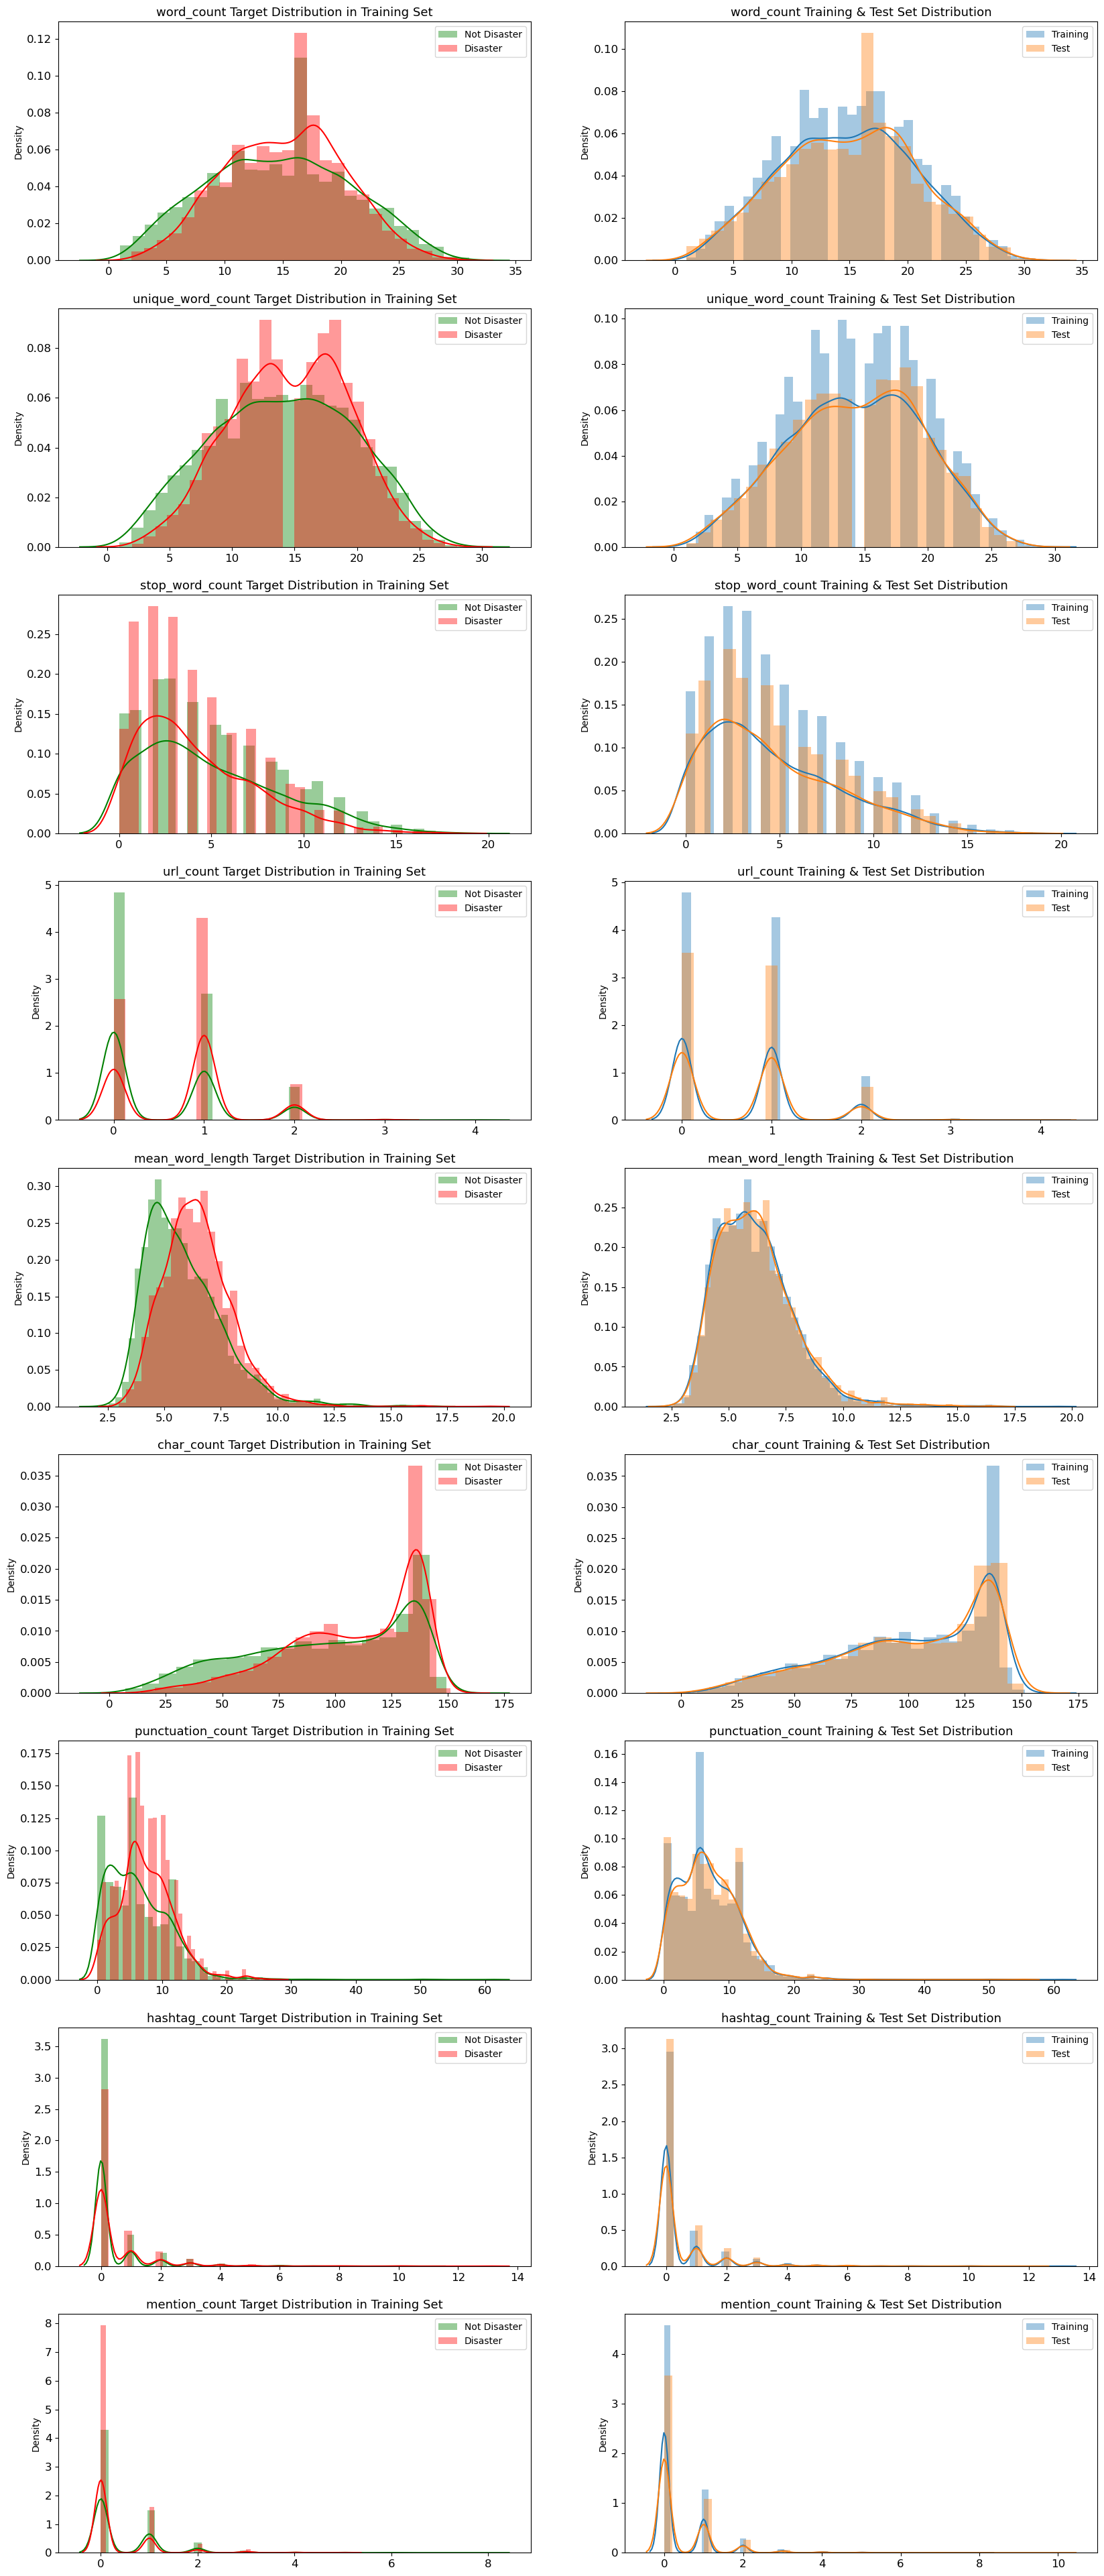

In [28]:


fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, feature in enumerate(METAFEATURES):
        sns.distplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
        sns.distplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')
        sns.distplot(train[feature], label='Training', ax=axes[i][1])
        sns.distplot(test[feature], label='Test', ax=axes[i][1])
    
        for j in range(2):
            axes[i][j].set_xlabel('')
            axes[i][j].tick_params(axis='x', labelsize=12)
            axes[i][j].tick_params(axis='y', labelsize=12)
            axes[i][j].legend()
        axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
        axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()


### Inspecting Location Feature

Viewing number of unique values and 20 of the most and least common locations

In [29]:
print(train['location'].nunique())

3342


There are way too many different locations. So there may be possible duplicates of places.

**For Ex:**

- 'Mumbai, India':'India'

- 'Ireland, Britain':'Britain'

- 'United States':'USA'

Lets view the most common places.

<AxesSubplot:xlabel='location'>

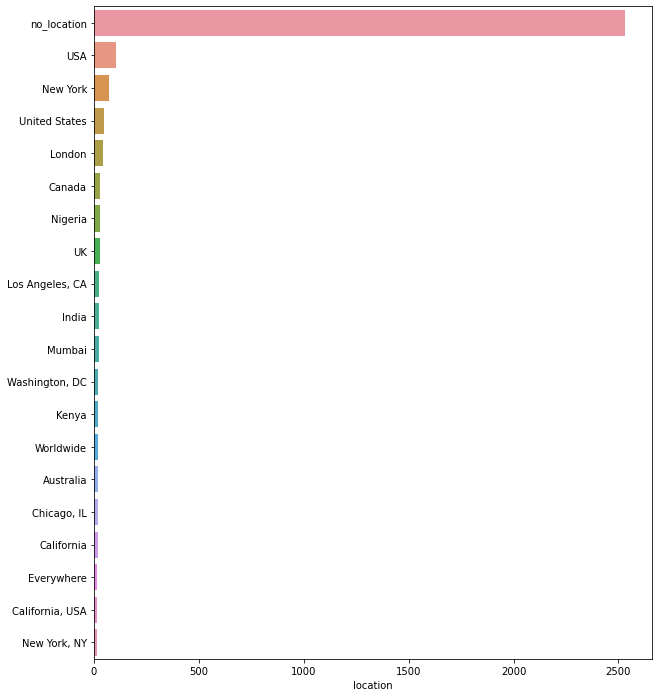

In [77]:
# Viewing first 20 most common locations
figure = plt.figure(figsize=(10,12))
sns.barplot(y=train['location'].value_counts().index[:20], x=train['location'].value_counts()[:20])

Lets view the least common places

<AxesSubplot:xlabel='location'>

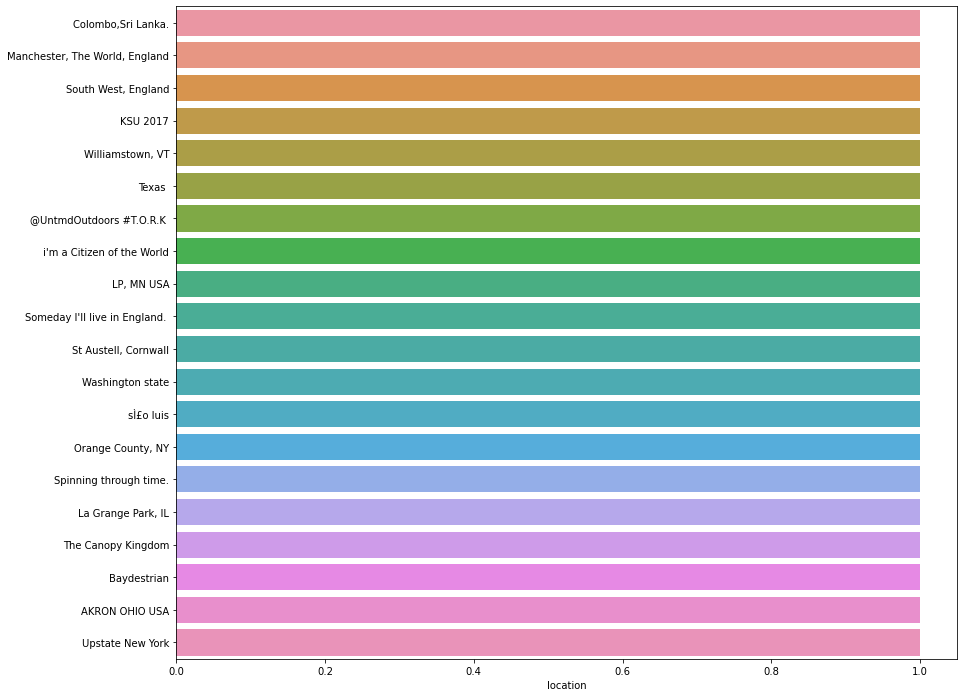

In [31]:
# Viewing last 20 least common locations
figure = plt.figure(figsize=(14,12))
sns.barplot(y=train['location'].value_counts().index[-20:], x=train['location'].value_counts()[-20:])

In [88]:
#异常值处理 但是没看懂

df_mislabeled = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
#df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.head()

,id,keyword,location,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
text,,,,,,,,,,,,,
death,2,1,1,2,1,1,1,1,1,1,1,1,1
rt notexplain onli known imag infam hijack db cooper,2,1,1,2,1,1,1,1,1,1,1,1,1
pbban armageddon not kill flag onli fast xp reason,2,1,1,2,1,1,1,1,2,2,2,1,1
allah describ pile up wealth think would last forev descript peopl hellfir in surah humaza reflect,3,1,3,2,1,1,1,1,1,1,1,1,1
hot funtenna hijack comput send data sound wave prebreak best,17,1,13,2,1,1,1,1,1,1,1,1,1


<a id='3'></a>
## Text Preprocessing


### Text PreProcessing Method:
- **LOWERCASE:** Make all words **UPPERCASE** or **lowercase**
- **STOPWORDS:** Remove stopwords - words that commonly come up and don't really have much meaning. For Ex: "I"
- **TOKENIZATION:** Basically splitting strings into numbers  we want
- **NOISE:** Removing Punctuation, Numbers, etc.

### OPTIONAL:
- **STEMMING:** Transforming words to their base root by cutting off the end of the word. (e.g. 'Running', 'Runner' = 'Run). Some words may be cut off too much (e.g. 'Spotify' -> 'Spotif') but it doesn't make a big difference
- **LEMMATIZATION:** Similar to stemming, except instead of cutting off the end of the word it basically counts similar words as one lemma. (e.g. 'Great', 'Good' = 'Good') Note: We don't include this step because we already used stemming so it isn't necessary.

Remember, you do need to use all of these steps. An extensive text preprocessing method may lead to worse results.

### Lowercase Text

We lowercase every word so the model doesn't treat an uppercased version different from the lowercased version

**For example:**
- EARTH and earth are supposed to be identical


In [32]:
def lowercase_text(text):
    text = text.lower()
    return text

train['text'] = train['text'].apply(lambda x: lowercase_text(x))
test['text'] = test['text'].apply(lambda x: lowercase_text(x))

In [33]:
train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

### Removing Text Noise

We create a prebuilt function and call it in order to remove punctuation, html tags, urls, numbers, etc.

In [34]:
# Removing punctuation, html tags, symbols, numbers, etc.
def remove_noise(text):
    # Dealing with Punctuation
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

We then use this function in order to deal with Text Noise

In [35]:
# Calling remove_noise function in order to remove noise
train['text'] = train['text'].apply(lambda x: remove_noise(x))
test['text'] = test['text'].apply(lambda x: remove_noise(x))

In [36]:
train['text'].head(20)

0     our deeds are the reason of this earthquake ma...
1                 forest fire near la ronge sask canada
2     all residents asked to shelter in place are be...
3      people receive wildfires evacuation orders in...
4     just got sent this photo from ruby alaska as s...
5     rockyfire update  california hwy  closed in bo...
6     flood disaster heavy rain causes flash floodin...
7     im on top of the hill and i can see a fire in ...
8     theres an emergency evacuation happening now i...
9      im afraid that the tornado is coming to our area
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah wait a...
12    raining flooding florida tampabay tampa  or  d...
13                flood in bago myanmar we arrived bago
14    damage to school bus on  in multi car crash br...
15                                         whats up man
16                                        i love fruits
17                                     summer is

### Removing Stopwords

We will be using the NLP library in order to remove the stopwords

In [37]:
!pip install nlppreprocess
from nlppreprocess import NLP

nlp = NLP()

train['text'] = train['text'].apply(nlp.process)
test['text'] = test['text'].apply(nlp.process)  

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


In [38]:
train['text'].head(20)

0     our deeds are reason earthquake may allah forg...
1                 forest fire near la ronge sask canada
2     residents asked shelter in place are being not...
3     people receive wildfires evacuation orders in ...
4     just got sent photo from ruby alaska smoke fro...
5     rockyfire update california hwy closed in dire...
6     flood disaster heavy rain causes flash floodin...
7                 im top hill and can see fire in woods
8     theres emergency evacuation happening now in b...
9                     im afraid tornado coming our area
10                 three people died from heat wave far
11    haha south tampa getting flooded hah wait seco...
12    raining flooding florida tampabay tampa days i...
13                flood in bago myanmar we arrived bago
14        damage school bus in multi car crash breaking
15                                         whats up man
16                                          love fruits
17                                        summer

### Stemming

We will use a stemmer to stem each word so the word will be transformed to its root word

In [39]:
stemmer = SnowballStemmer("english")

def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(text)

train['text'] = train['text'].apply(stemming)
test['text'] = test['text'].apply(stemming)

<font color='red' size=5><b>For Fun WordCloud!</b></font>
<br>
<br>
We will look at the most common words in the tweets through a wordcloud.

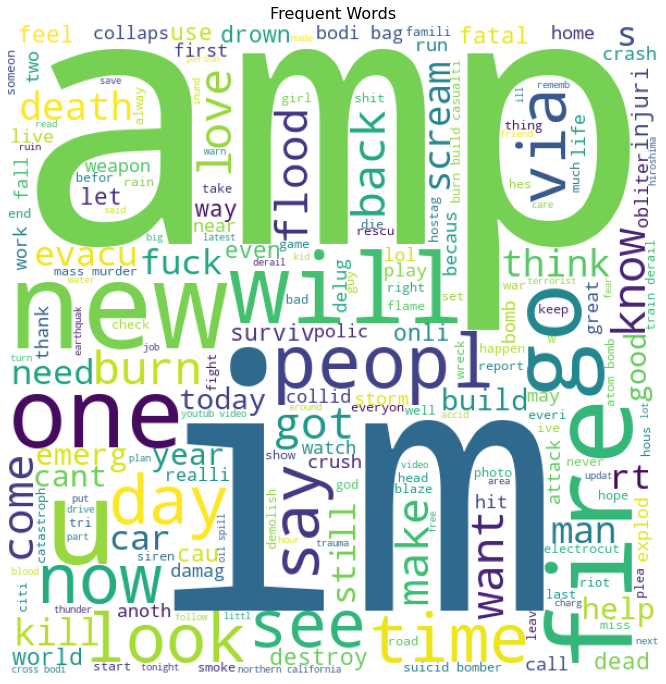

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=[12, 12])
wordcloud = WordCloud( background_color='white',
                        width=600,
                        height=600).generate(" ".join(train['text']))
ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title('Frequent Words',fontsize=16);

<a id='4'></a>
## Transforming Tokens to Vectors
<br>
### TF-IDF:
TFIDF penalizes words that come up too often and don't really have much use. So it rescales the frequency of words that are common which makes scoring more balanced. This approach however does worse than using Bag of Words, the next step. My assumption is that we already removed stop words from the text making this method redundant

### **Formula:**
![](https://cdn.searchenginejournal.com/wp-content/uploads/2019/10/screenshot-1.png)


`tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
tfidf.fit(train['text'])
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])`

### Bag of Words:

Bag of words basically takes every single unique word that appears in the dataset and turns all of them into a feature. Sentences that contain the word are marked with a 1.


**For Example:**
![](https://miro.medium.com/max/2424/1*yYt2gduO0KpYPX0ewT4BHA.png)

For the first sentence "This is the first document" notice how there is a 1 under each word that is included in the sentence. This is similar to how hot-encoding works.

In [41]:
# Using CountVectorizer to change the teweets to vectors
count_vectorizer = CountVectorizer(analyzer='word', binary=True)
count_vectorizer.fit(train['text'])

train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])


# Printing first vector
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


<a id='5'></a>
## Modelling
<br>
Create model for cross-validation scores and submission

Lets assign the target feature to a variable

In [42]:
y = train['target']

### Model Setup & Cross-Validation
<br>
Setting up our MultinomialNB model and using it to see our cross-validation score. We then train the model for submission.

Creating the model for cross-validation score

In [43]:
# Creating a simple MultinomialNB model
model = MultinomialNB(alpha=1)

# Using cross validation to print out our scores
scores = model_selection.cross_val_score(model, train_vectors, y, cv=3, scoring="f1")
scores

array([0.67047619, 0.65773552, 0.7158609 ])

We will now train and predict our model for submission

In [44]:
# Training model with train_vectors and target variable
model.fit(train_vectors, y)

MultinomialNB(alpha=1)

<a id='6'></a>
## Submission
<br>
Predicting model then submitting to competition

In [45]:
sample_submission = pd.read_csv("sample_submission.csv")

In [46]:
# Predicting model with the test data that was vectorized (test_vectors)
sample_submission['target'] = model.predict(test_vectors)

In [47]:
# Viewing submission
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [48]:
# Submission
sample_submission.to_csv("submission.csv", index=False)